![](/images/blog/linear-regression.png)

I was recently invited to give a guest lecture in the course [ENM 375 Biological Data Science I - Fundamentals of Biostatistics](https://catalog.upenn.edu/courses/enm/) at the University of Pennsylvania on the topic of [linear regression](https://en.wikipedia.org/wiki/Linear_regression) in Python. As part of my lecture, I walked through this notebook. It might serve as a useful reference, covering everything from simulation and fitting to a wide variety of diagnostics. The walkthrough includes explanations of how to do everything in vanilla [`numpy`](https://numpy.org/)/[`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/), and [`statsmodels`](https://www.statsmodels.org/). As a bonus, there's even a section on [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) at the end.

Read on for more!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/linear_regression.ipynb)

<!-- TEASER_END -->

In [0]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit
sns.set_style('ticks')
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1 Simulating data from linear models

Simulate $N$ data points from the linear model

$$y = X\beta + \epsilon \;,\quad  \epsilon \sim \mathcal{N}(0, \sigma)$$

We will make the first column of $X$ all 1's so that the first element of $\beta$ represents an intercept. For example:

\begin{align}
y &= X\beta + \epsilon \\
\begin{bmatrix} 
y_1 \\
y_2 \\
\vdots
\end{bmatrix} &= \begin{bmatrix} 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots
\end{bmatrix} \begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix} + \begin{bmatrix} 
\epsilon_1 \\
\epsilon_2 \\
\vdots
\end{bmatrix} \\
y_i &= \beta_0 + \beta_1 x_i + \epsilon_i, \quad i=1,2,\ldots, N
\end{align}

In [0]:
n = 300
beta = np.array([0, 2.3])[:, None]
sigma = 4
x = np.concatenate([np.ones((n, 1)), stats.uniform(0, 10).rvs(size=n)[:, None]], axis=1)
eps = stats.norm(0, sigma).rvs(size=n)[:, None]
#y = np.dot(x, beta) + eps
y = x @ beta + eps
p = x.shape[1]

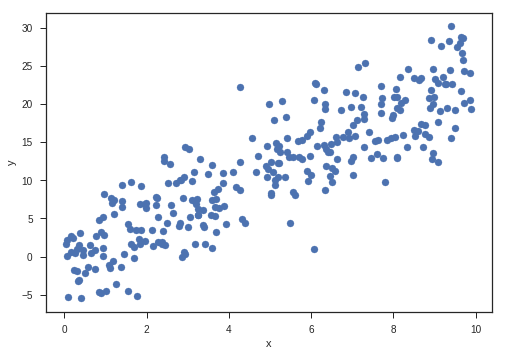

In [0]:
plt.scatter(x[:, 1], y)
plt.xlabel('x')
_ = plt.ylabel('y')

# 2 Ordinary least squares parameter fitting

## 2.1 Normal equations

We want to find an estimate $\hat{\beta}$ given some observations $y, X$ such that we make $X\hat{\beta}$ as close as possible to $y$ in terms of squared differences:

\begin{align}
\hat{\beta} &= \mathrm{arg} \min_\beta ||y - X\beta ||^2 \\
&= \mathrm{arg} \min_\beta \; (y - X\beta)^T(y - X\beta) \\
&= \mathrm{arg} \min_\beta \; y^Ty-(X\beta)^T y - y^T(X\beta)+(X\beta)^T(X\beta) \\
&= \mathrm{arg} \min_\beta \; y^Ty- 2\beta^T X^T y +\beta^T X^T X\beta
\end{align}

Taking the derivative of this expression and looking for critical points, we find

\begin{align}
\frac{d}{d\hat{\beta}}\left(y^Ty- 2\hat{\beta}^T X^T y +\hat{\beta}^T X^T X\hat{\beta}\right) &= 0 \\
-2 X^T y +2 X^T X\hat{\beta} &= 0 \\
2 X^T X\hat{\beta} &= 2 X^T y \\
X^T X\hat{\beta} &= X^T y \\
(X^T X)^{-1} X^T X\hat{\beta} &= (X^T X)^{-1} X^T y \\
\hat{\beta} &= (X^T X)^{-1} X^T y
\end{align}

In [0]:
#beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y)
beta_hat = np.linalg.inv(x.T @ x) @ x.T @ y
beta_hat

array([[-0.57631717],
       [ 2.40489883]])

## 2.2 Covariance equation

We can also estimate the slope $\hat{\beta}_1$ as
$$\hat{\beta}_1 = \frac{\mathrm{Cov}(x_{:, 1}, y)}{\mathrm{Var}(x_{:, 1})}$$

In [0]:
((var_x , cov_xy),
 (cov_yx, var_y)) = np.cov(x[:, 1], y, rowvar=False, ddof=1)
cov_xy / var_x

2.404898825076264

## 2.3 Rescaled correlation coefficient

We can also estimate the slope $\hat{\beta}_1$ using the correlation coefficient $r_{xy}$ and the sample standard deviations of $x$ and $y$, respectively

$$\hat{\beta}_1 = r_{xy}\frac{s_y}{s_x}$$

In [0]:
r_xy = stats.pearsonr(x[:, 1].ravel(), y.ravel())[0]
s_x = np.std(x[:, 1], ddof=1)
s_y = np.std(y, ddof=1)
r_xy * (s_y / s_x)

2.4048988250762653

This basically works because the Pearson correlation is the slope of the least squares line through the data points after they've been centered and scaled.

$$z_y = \frac{y - \bar{y}}{s_y}, \quad z_x = \frac{x - \bar{x}}{s_x}$$

Centering doesn't change the slope, but we can undo the scaling (division/multiplication by standard deviation).

In [0]:
z_y = (y - np.mean(y)) / np.std(y, ddof=1)
z_x = (x[:, 1] - np.mean(x[:, 1])) / np.std(x[:, 1], ddof=1)
beta_z_hat = (z_x.T @ z_x)**-1 * z_x.T @ z_y
beta_z_hat, stats.pearsonr(x[:, 1].ravel(), y.ravel())[0]

(array([0.87330956]), 0.8733095589363401)

## 2.4 `scikit-learn`

`sklearn.linear_model.LinearRegression` will automatically add a column of 1's to $X$ and store the coefficient for that column (the intercept) at `model.intercept_`. Since we already have 1's in our $X$ matrix, we can pass `fit_intercept=False` to avoid this.

In [0]:
model = LinearRegression(fit_intercept=False).fit(x, y)
model.coef_

array([[-0.57631717,  2.40489883]])

We can also pass just the $X_{:, 1}$ values, but note that we have to make sure to pass $X$ as a matrix whose rows correspond to observations and whose columns correspond to features, so we expand the 1-dimensional `x[:, 1]` back to a column vector `x[:, 1][:, None]`. 

In [0]:
model = LinearRegression().fit(x[:, 1][:, None], y)
model.intercept_, model.coef_

(array([-0.57631717]), array([[2.40489883]]))

## 2.5 `statsmodels`

`statsmodels` uses an R-like "formula API" which allows you to specify which variables (on the right of the `~`) you want to use to fit what other variable (on the left of the `~`) where the variables are column names in a `pandas` DataFrame which you might load from a table of data on disk. 

In [0]:
df = pd.DataFrame({'x': x[:, 1], 'y': y.ravel()})
results = smf.ols('y ~ x', data=df).fit()
results.params

Intercept   -0.576317
x            2.404899
dtype: float64

`statsmodels` computes a bunch of useful information about the regression, some of which we will dig into below.

In [0]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     957.6
Date:                Tue, 16 Apr 2019   Prob (F-statistic):           4.47e-95
Time:                        16:43:47   Log-Likelihood:                -837.20
No. Observations:                 300   AIC:                             1678.
Df Residuals:                     298   BIC:                             1686.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5763      0.447     -1.288      0.199      -1.457       0.304
x              2.4049      0.078     30.946      0.000       2.252       2.558
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.334
Skew:                           0.075   Prob(JB):                        0.846
Kurtosis:                       2.934   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 3 Residuals and diagnostics

In the context of prediction (or projection), the values in $y$ predicted by our model (or projected onto the subspace spanned by the columns of $X$) are

$$\hat{y} = X\hat{\beta}$$

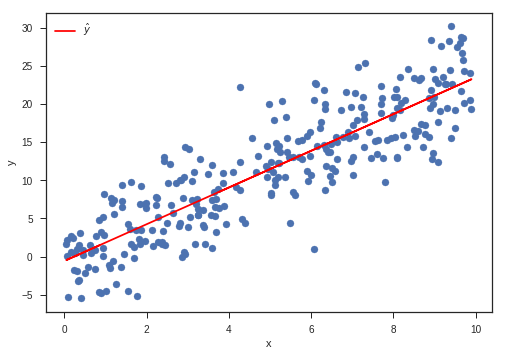

In [0]:
#y_hat = np.dot(x, beta_hat)
y_hat = x @ beta_hat
plt.scatter(x[:, 1], y)
plt.plot(x[:, 1], y_hat, c='r', label=r'$\hat{y}$')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()

The "residuals" of the fit are the difference between this predicted $\hat{y} = X\hat{\beta}$ and the original $y$ values:

$$r = X\hat{\beta} - y$$

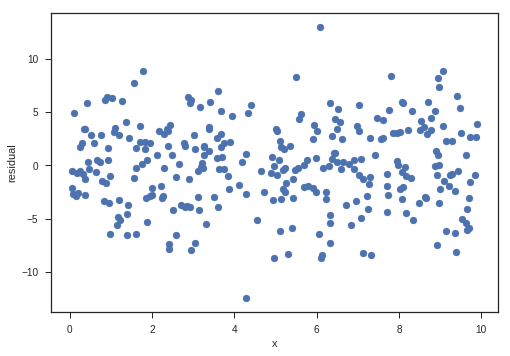

In [0]:
res = y_hat - y
plt.scatter(x[:, 1], res)
plt.xlabel('x')
_ = plt.ylabel('residual')

## 3.1 Normality

We can look at the distribution of the residuals using either a histogram or a QQ plot, and test it for normality. There are many tests for normality, but one common one is the ["omnibus" test](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test#Omnibus_K2_statistic) mentioned in the `statsmodels` summary table and implemented in [`scipy.stats.normaltest()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). This tests the null hypothesis that the residuals are in fact normally distributed.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


NormaltestResult(statistic=array([0.29369087]), pvalue=array([0.86342742]))

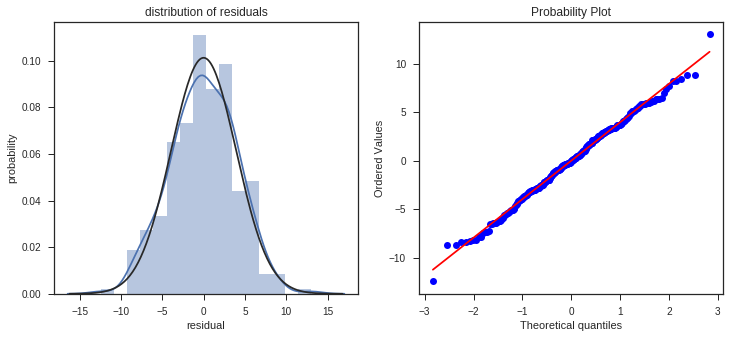

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(res, fit=stats.norm, ax=ax1)
ax1.set_title('distribution of residuals')
ax1.set_xlabel('residual')
ax1.set_ylabel('probability')
_ = stats.probplot(res.ravel(), plot=ax2)
stats.normaltest(res)

## 3.2 Linearity

If the relationship between the variables really is linear, we expect the residuals to be scattered around zero (both above and below) across the x-axis. One way to test this quantitatively is with the [Harvey-Collier test](https://www.sciencedirect.com/science/article/pii/0304407677900574) (tests the null hypothesis that the relationship between the variables is linear):

In [0]:
sms.linear_harvey_collier(results)

Ttest_1sampResult(statistic=-0.7919642303667419, pvalue=0.4290157442729646)

## 3.3 Homoscedasticity

To be more specific, we expect to see that the residuals are scattered around zero with a variance that doesn't depend on $X$ (or anything else really). One way to test this quantitatively is with the [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) (tests the null hypothesis that the data are homoscedastic).

In [0]:
lm, lm_pvalue, fvalue, f_pvalue = sms.het_breuschpagan(res, x)
lm_pvalue, f_pvalue

(0.20866312328816872, 0.20996715986494346)

## 3.4 Independence

For ordered data, we can plot a scatterplot of the residuals versus observation number and/or the autocorrelation of the residuals. Even if data are nominally unordered, oftentimes the order of rows in a data table can reveal something about the time periods in which data were collected, etc. The Durbin-Watson test is used by `statsmodels` to attempt to quantify the degree of correlations in the residuals - it doesn't come with an automatically computed p-value, however, and instead is simply a number between 0 and 4 which should be close to 2 if there is no sequential correlation in the residuals.

(array([[0.00374734]]),
 (0.0823229682858566, 0.15492805351362463),
 array([1.97885865]))

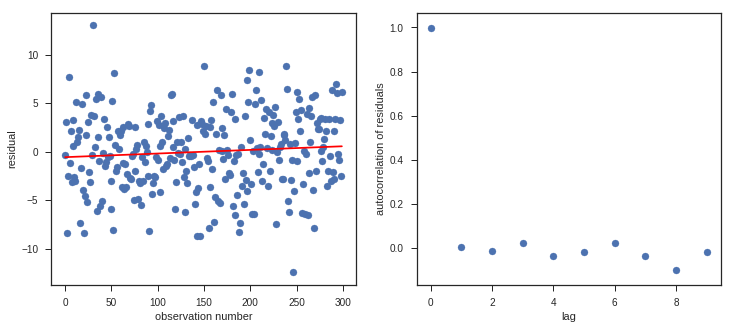

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ord_model = LinearRegression().fit(np.arange(n)[:, None], res)
ord_hat = ord_model.predict(np.arange(n)[:, None])
ax1.scatter(np.arange(n), res)
ax1.plot(np.arange(n), ord_hat, c='r')
ax1.set_xlabel('observation number')
ax1.set_ylabel('residual')
autocorr = np.correlate(res.ravel(), res.ravel(), 'full')[len(res)-1:] / np.var(res, ddof=1) / len(res)
ax2.scatter(np.arange(10), autocorr[:10])
ax2.set_xlabel('lag')
ax2.set_ylabel('autocorrelation of residuals')
ord_model.coef_, stats.pearsonr(np.arange(n), res.ravel()), sms.durbin_watson(res)

## 3.5 First-order conditions

If we picked our estimate for the slope $\hat{\beta}_1$ correctly, it should "regress out" all the correlation between $X$ and $y$ such that nothing is left in the residuals.

(array([[1.78325034e-15]]), 1.3085596706121992e-15)

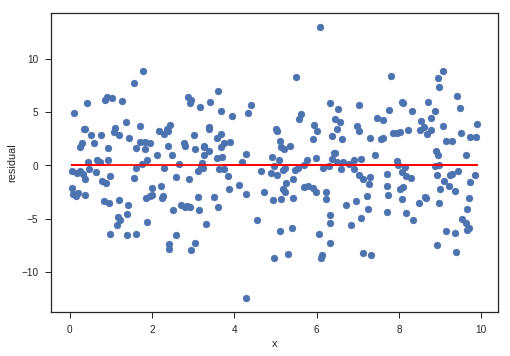

In [0]:
res_model = LinearRegression().fit(x[:, 1][:, None], res)
res_hat = res_model.predict(x[:, 1][:, None])
plt.scatter(x[:, 1], res)
plt.plot(x[:, 1], res_hat, c='r')
plt.xlabel('x')
plt.ylabel('residual')
res_model.coef_, stats.pearsonr(x[:, 1].ravel(), res.ravel())[0]

#4 Inference and significance

So far we have covered how to estimate and diagnose the point estimates of the parameters $\hat{\beta}$. Now we will discuss how to quantify the uncertainty in the model (and thereby assess the significance of the relationships quantified by $\hat{\beta}$).

## 4.1 Standard error of the model

This process starts with estimating the variance of the error term $\epsilon$, which we called $\sigma^2$ above. We can form an estimate $\hat{\sigma}^2$ of this variance from the residuals:

$$\hat{\sigma}^2 = \frac{r^T r}{n - p}$$

where $n-p$ represents the degrees of freedom in the regression (the number of observations $n$ minus the number of coefficients we fitted $p$).

This quantity is computed by `statsmodels` and saved as `results.scale`.

In [0]:
#var_hat = np.dot(res.T, res) / (n - p)
var_hat = (res.T @ res) / (n - p)
var_hat, results.scale, sigma**2

(array([[15.64464372]]), 15.644643722932866, 16)

## 4.2 Standard errors of the coefficients

Our estimates for the variances of our estimates of the coefficients $\hat{\beta}$ are then

$$\hat{\mathrm{Var}}[\hat{\beta} \mid X] = \hat{\sigma}_\beta^2 = \hat{\sigma}^2 (X^T X)^{-1}$$

In [0]:
#beta_var_hat = var_hat * np.linalg.inv(np.dot(x.T, x))
beta_var_hat = var_hat * np.linalg.inv(x.T @ x)
beta_var_hat

array([[ 0.20025175, -0.02990742],
       [-0.02990742,  0.00603941]])

`statsmodels` prints the square root of the estimated variances for each coefficient in $\hat{\beta}$ in the summary table, calling them "std err'', and stores them in `results.bse`.

In [0]:
beta_sigma_hat = np.sqrt(np.diag(beta_var_hat))
(beta_sigma_hat, results.bse)

(array([0.44749497, 0.07771362]), Intercept    0.447495
 x            0.077714
 dtype: float64)

We can use these standard errors to both

  1. test to see if the coefficients are significant (using a t-test), and
  2. compute confidence intervals for the coefficients.

## 4.3 Significance of the coefficients

To do (1) we first compute the t-statistic against the null hypothesis that the coefficient is zero (stored by `statsmodels` in `results.tvalues`):

In [0]:
t_stat = beta_hat.T / beta_sigma_hat
t_stat, results.tvalues

(array([[-1.28787407, 30.9456527 ]]), Intercept    -1.287874
 x            30.945653
 dtype: float64)

We can then compute two-tailed p-values (since we plan to reject the null hypothesis of $\beta = 0$ regardless of the sign of the coefficient) by comparing the t-statistics against a t-distribution with $n - p$ degrees of freedom (stored by `statsmodels` in `results.pvalues`):

In [0]:
stats.t(df=n-p).sf(t_stat) * 2, results.pvalues

(array([[1.80121102e+00, 4.47204581e-95]]), Intercept    1.987890e-01
 x            4.472046e-95
 dtype: float64)

## 4.4 Confidence intervals for the coefficients

To do (2), we find the appropriate percentiles of t-distribution we just used above for calling the p-values, scale them by $\hat{\sigma}_\beta$, and shift them by $\hat{\beta}_i$:

In [0]:
beta_hat + stats.t(df=n-p).ppf([0.025, 0.975]) * beta_sigma_hat[:, None]

array([[-1.4569678 ,  0.30433347],
       [ 2.25196179,  2.55783586]])

We can also perform this shifting and scaling using the `loc` and `scale` kwargs in `scipy.stats`:

In [0]:
stats.t(loc=beta_hat, scale=beta_sigma_hat[:, None], df=n-p).ppf([0.025, 0.975])

array([[-1.4569678 ,  0.30433347],
       [ 2.25196179,  2.55783586]])

`statsmodels` also computes 95% confidence intervals for the coefficients and prints them in the table under the heading "[0.025 0.975]". You can also compute any confidence intervals you like by calling `results.conf_int()`: 

In [0]:
results.conf_int(0.05)

,0,1
Intercept,-1.456968,0.304333
x,2.251962,2.557836


# 5 Multiple linear regression

In general each observed data point may have multiple features (or things we measure about it). These correspond to new rows of $X$ and new elements in $\beta$ in the matrix equation for our linear model:

\begin{align}
y &= X\beta + \epsilon \\
\begin{bmatrix} 
y_1 \\
y_2 \\
\vdots
\end{bmatrix} &= \begin{bmatrix} 
1 & x_{11} & x_{12} & x_{13} & \cdots \\
1 & x_{21} & x_{22} & x_{23} & \cdots\\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix} \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 \\
\vdots
\end{bmatrix} + \begin{bmatrix} 
\epsilon_1 \\
\epsilon_2 \\
\vdots
\end{bmatrix}
\end{align}

## 5.1 Simulation

Our simulation code still looks very similar:

In [0]:
n = 300
beta = np.array([0, 2.3, -1.4, 0.5])[:, None]
sigma = 4
x = np.concatenate([np.ones((n, 1)), stats.uniform(0, 10).rvs(size=(n, 3))], axis=1)
eps = stats.norm(0, sigma).rvs(size=n)[:, None]
#y = np.dot(x, beta) + eps
y = x @ beta + eps

## 5.2 Normal equations

and the same exact normal equations we used above will still work:

In [0]:
#beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y)
beta_hat = np.linalg.inv(x.T @ x) @ x.T @ y
beta_hat

array([[ 0.73279227],
       [ 2.22644238],
       [-1.47253548],
       [ 0.55649708]])

## 5.3 Multiple linear regression as multiple single variable linear regressions

Plotting (and thinking) in higher dimensions is tricky, but one convenient way to think about multiple linear regression is that it estimates $\hat{\beta}_i$ by performing a simple linear regression between $X_{:, i}$ and a version of $y$ that has been adjusted for all the other columns of $X$.

In the code block below, `y23` represents a version of $y$ that has been adjusted for the 2nd and 3rd columns of $X$. What I mean here by "adjusted" is simply that the linear dependence on those columns has been "regressed out" (i.e., subtracted from) $y$. To do this in code, I just take $y$ and subtract the $\hat{y}$ I would get if I used only the 2nd and 3rd columns of $X$ to predict $\hat{y}$. Mathematically:

$$y_{23} = y - \hat{y}_{23}$$
$$\hat{y}_{23} = X_{:,23} \times \hat{\beta}_{23}$$

where $X_{:,23}$ represents all the rows (:) but only the 2nd and 3rd columns of $X$, and $\hat{\beta}_{23}$ represents the corresponding entries of $\hat{\beta}$.

Note that in this case I'm not regressing out the intercept $\hat{\beta}_0$ - this is a bit of an oversimplification. In this specific simulation, we set the true value of the intercept $\beta_0$ to 0, but this would not be true in general. Moreover, our estimate of $\hat{\beta}_0$ is nonzero. To be truly correct here, we could either add our estimated intercept $\hat{\beta}_0$ to the red line (e.g., `ax1.plot(x[:, [0, 1]], x[:, [0, 1]] * beta_hat[[0, 1]], ...)`), or we could ensure that the adjusted $y$ values are also adjusted for the intercept (e.g., replace `y23` with `y023 = y - x[:, [0, 2, 3]] @ beta_hat[[0, 2, 3]]`). In this specific case, it wouldn't change the appearance of the plot by much because $\hat{\beta}_0$ is relatively small.

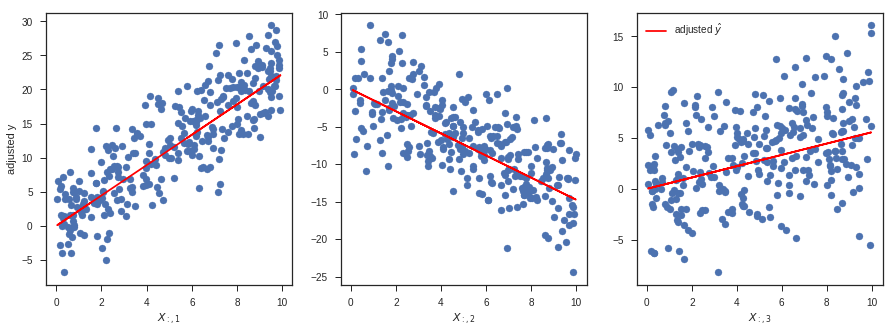

In [0]:
#y23 = y - np.dot(x[:, [2, 3]], beta_hat[[2, 3]])
#y13 = y - np.dot(x[:, [1, 3]], beta_hat[[1, 3]])
#y12 = y - np.dot(x[:, [1, 2]], beta_hat[[1, 2]])
y23 = y - x[:, [2, 3]] @ beta_hat[[2, 3]]
y13 = y - x[:, [1, 3]] @ beta_hat[[1, 3]]
y12 = y - x[:, [1, 2]] @ beta_hat[[1, 2]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(x[:, 1], y23)
ax1.plot(x[:, 1], x[:, 1] * beta_hat[1], c='r', label=r'adjusted $\hat{y}$')
ax1.set_xlabel(r'$X_{:, 1}$')
ax1.set_ylabel('adjusted y')
ax2.scatter(x[:, 2], y13)
ax2.plot(x[:, 2], x[:, 2] * beta_hat[2], c='r', label=r'adjusted $\hat{y}$')
ax2.set_xlabel(r'$X_{:, 2}$')
ax3.scatter(x[:, 3], y12)
ax3.plot(x[:, 3], x[:, 3] * beta_hat[3], c='r', label=r'adjusted $\hat{y}$')
ax3.set_xlabel(r'$X_{:, 3}$')
_ = plt.legend()

All of the diagnostics discussed above can be applied to the residuals just as before.

## 5.4 `scikit-learn` 

`sklearn.linear_model.LinearRegression` works just as before:

In [0]:
model = LinearRegression().fit(x[:, 1:], y)
model.intercept_, model.coef_

(array([0.73279227]), array([[ 2.22644238, -1.47253548,  0.55649708]]))

## 5.5 `statsmodels`

`statsmodels` also works just as before:

In [0]:
df = pd.DataFrame({'x1': x[:, 1], 'x2': x[:, 2], 'x3': x[:, 3], 'y': y.ravel()})
results = smf.ols('y ~ x1 + x2 + x3', data=df).fit()
results.params

Intercept    0.732792
x1           2.226442
x2          -1.472535
x3           0.556497
dtype: float64

In [0]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     419.8
Date:                Tue, 16 Apr 2019   Prob (F-statistic):          2.80e-106
Time:                        16:43:50   Log-Likelihood:                -842.59
No. Observations:                 300   AIC:                             1693.
Df Residuals:                     296   BIC:                             1708.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7328      0.763      0.960      0.338      -0.770       2.235
x1             2.2264      0.078     28.718      0.000       2.074       2.379
x2            -1.4725      0.085    -17.341      0.000      -1.640      -1.305
x3             0.5565      0.080      6.987      0.000       0.400       0.713
==============================================================================
Omnibus:                        0.459   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.589
Skew:                          -0.041   Prob(JB):                        0.745
Kurtosis:                       2.799   Cond. No.                         30.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 6 Logistic regression

## 6.1 The logistic regression model

The logistic regression model is

$$y_i \sim \mathrm{Bernoulli}(p_i), \quad \ln \frac{p_i}{1-p_i} = X_{i,:}^T\beta $$

were $y_i$ is a boolean variable representing the $i$th observation, $\ln\frac{p_i}{1-p_i}$ represents the log odds for the $i$th observation being a success, $X_{i,:}$ represents all the features we observe for the $i$th observation, and $\beta$ is a vector of weights.

The function

$$f(p) = \ln \frac{p}{1-p}$$

is called the logit function. Its inverse function is 

$$f^{-1}(x) = \frac{1}{1+\exp(-x)}$$

and is called the logistic function (but is called `scipy.special.expit()` in `scipy`).

## 6.2 Simulating from a logistic model

Our simulation looks similar to the linear regression simulation above, except for the following  important differences:

  1. There is no error term $\epsilon$. In the logistic regression model, randomness comes directly from the Bernoulli distribution.
  2. We use the logistic function (`scipy.special.expit()`) to "link" the linear combination of our predictors $X$ weighed by our weights $\beta$ to the Bernoulli distribution parameter $p$. Don't think too hard about it now, but this is the basic principle underlying generalized linear models (GLMs). Conveniently, the range of the logistic function is $(0, 1)$, which means that any number it returns will be a valid Bernoulli parameter $p$.

In [0]:
n = 200
beta = np.array([0, 2.3])[:, None]
x = np.concatenate([np.ones((n, 1)), stats.uniform(-5, 10).rvs(size=n)[:, None]], axis=1)
#p = expit(np.dot(x, beta))
p = expit(x @ beta)
y = stats.bernoulli(p).rvs()

We can visualize our simulated data on a scatterplot as before, but this time the $y$-values can take on only two values (1 and 0, the support of the Bernoulli distribution). We can visualize the relationship between $x$ and the probability that a point at that $x$ value will result in a successful Bernoulli trial as a function $p(x)$ (a logistic function parameterized by $\beta$), which is the red curve in the plot below.

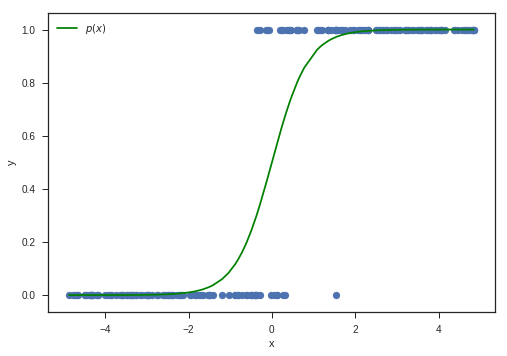

In [0]:
plt.scatter(x[:, 1], y)
idx = np.argsort(x[:, 1])
plt.plot(x[:, 1][idx], p[idx], c='g', label=r'$p(x)$')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()

## 6.3 Fitting logistic regression parameters

To draw the red curve above, we computed $p = \mathrm{expit}(X^T\beta)$ using the true value of $\beta$. Our goal when fitting the logistic regression model will be to compute estimates $\hat{\beta}$ directly from the observed data ($X$ and $y$) and thereby obtain an estimated probability curve $\hat{p}(x)=\mathrm{expit}(x^T\hat{\beta})$.

Unlike linear regression, there is no closed-form solution for estimating the logistic regression parameters $\beta$, so we will do this using iterative methods (usually some variation on Newton's method).

### 6.3.1 `scikit-learn`

In [0]:
model = LogisticRegression(fit_intercept=False, C=1e10).fit(x, y)
model.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[-0.16692746,  3.14947471]])

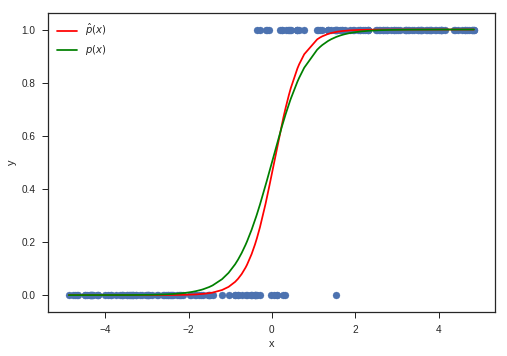

In [0]:
#p_hat = expit(np.dot(x, model.coef_.T))
p_hat = expit(x @ model.coef_.T)
plt.scatter(x[:, 1], y)
idx = np.argsort(x[:, 1])
plt.plot(x[:, 1][idx], p_hat[idx], c='r', label=r'$\hat{p}(x)$')
plt.plot(x[:, 1][idx], p[idx], c='g', label=r'$p(x)$')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()

### 6.3.2 `statsmodels`

In [0]:
df = pd.DataFrame({'x': x[:, 1], 'y': y.ravel()})
results = smf.logit('y ~ x', data=df).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.110929
         Iterations 10


Intercept   -0.166928
x            3.149494
dtype: float64

In [0]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
==============================================================
Model:              Logit            No. Iterations:   10.0000
Dependent Variable: y                Pseudo R-squared: 0.840  
Date:               2019-04-16 16:43 AIC:              48.3716
No. Observations:   200              BIC:              54.9683
Df Model:           1                Log-Likelihood:   -22.186
Df Residuals:       198              LL-Null:          -138.59
Converged:          1.0000           Scale:            1.0000 
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
Intercept   -0.1669    0.3803  -0.4389  0.6607  -0.9123  0.5785
x            3.1495    0.7331   4.2959  0.0000   1.7126  4.5864
==============================================================

"""

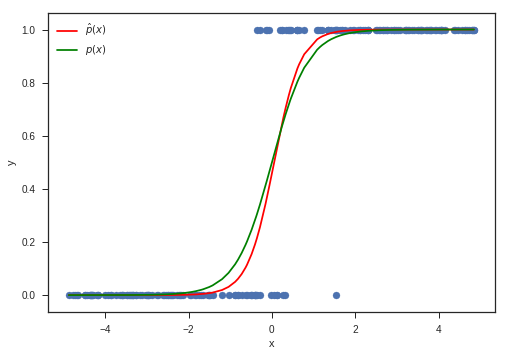

In [0]:
#p_hat = expit(np.dot(x, results.params[:, None]))
p_hat = expit(x @ results.params[:, None])
plt.scatter(x[:, 1], y)
idx = np.argsort(x[:, 1])
plt.plot(x[:, 1][idx], p_hat[idx], c='r', label=r'$\hat{p}(x)$')
plt.plot(x[:, 1][idx], p[idx], c='g', label=r'$p(x)$')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()